# Case Study 4

## Description

Use Random Forest and XGBoost to accurately predict bankruptcy. Tune your models for maximum accuracy, but include precision and recall as summary metrics.

[data](https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data)

### Email 1

From: Finance Department

To: Data Science Department

Subject: Financial Delinquency Project

We've collected our data. And we've noticed that you know what one of the biggest losses to our company is when companies go bankrupt and for our various investment strategies. So what we'd like to do is take a look at our historical data and see if there's any way that we can predict in the future that a company might go bankrupt, so that we can divest ourselves ahead of time.

### Email 2

From: Finance Department 

To: Data Science Department

Subject: RE: Financial Delinquency Project

Oh, and just to clarify, this dataset is collected over five years, but we don't care the exact year that a company will go bankrupt, just whether or not they will go bankrupt at all, based on the data. Thanks!


## Setup

### Load Libraries

In [1]:
# Import standard libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import sklearn libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Import other libraries
from scipy.io import arff
from statsmodels.stats.outliers_influence import variance_inflation_factor
import missingno
import os
import warnings
import xgboost
from xgboost import XGBClassifier

# Set options
pd.set_option("display.max_columns", None)
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000

warnings.filterwarnings("ignore")
get_ipython().run_line_magic("matplotlib", "inline")

### Load Data

In [2]:
# Iterate through files provided and make data frame
files = os.listdir('./data')
files.sort()
df = pd.DataFrame()
for i, filename in enumerate(files):
    file = "./data/"+filename
    data = arff.loadarff(file)
    df_temp = pd.DataFrame(data[0])
    df = pd.concat([df,df_temp])

In [3]:
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,0.249760,0.65980,0.166600,0.249760,497.42,0.73378,2.6349,0.249760,0.149420,43.370,1.2479,0.21402,0.119980,0.47706,0.50494,0.60411,1.45820,1.7615,5.9443,0.11788,0.149420,94.14,3.8772,0.56393,0.21402,1.7410,593.2700,0.50591,0.128040,0.662950,0.051402,0.128040,114.42,71.050,1.00970,1.52250,49.394,0.185300,0.110850,2.0420,0.37854,0.25792,2.2437,2.2480,348690.0,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,0.261140,0.51680,0.158350,0.258340,677.96,0.53838,2.0005,0.258340,0.152000,87.981,1.4293,0.24806,0.123040,NaN,0.39542,0.43992,88.44400,16.9460,3.6884,0.26969,0.152000,122.17,2.9876,2.98760,0.20616,1.6996,NaN,0.49788,0.121300,0.086422,0.064371,0.145950,199.49,111.510,0.51045,1.12520,100.130,0.237270,0.139610,1.9447,0.49988,0.33472,17.8660,17.8660,2304.6,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,0.312580,0.64184,0.244350,0.309060,794.16,0.45961,1.4369,0.309060,0.236100,73.133,1.4283,0.30260,0.189960,NaN,0.28932,0.37282,86.01100,1.0627,4.3749,0.41929,0.238150,176.93,2.0630,1.42740,0.31565,1.3090,2.3019,0.51537,0.241140,0.322020,0.074020,0.231170,165.51,92.381,0.94807,1.01010,96.372,0.291810,0.222930,1.0758,0.48152,0.48474,1.2098,2.0504,6332.7,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,0.092704,0.30163,0.094257,0.092704,917.01,0.39803,3.2537,0.092704,0.071428,79.788,1.5069,0.11550,0.062782,0.17193,0.57353,0.36152,0.94076,1.9618,4.6511,0.14343,0.071428,91.37,3.9948,0.37581,0.11550,1.3562,NaN,0.57353,0.088995,0.401390,0.069622,0.088995,180.77,100.980,0.28720,1.56960,84.344,0.085874,0.066165,2.4928,0.30734,0.25033,2.4524,2.4524,20545.0,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,0.187320,0.33147,0.121820,0.187320,1133.20,0.32211,1.6307,0.187320,0.115530,57.045,NaN,0.19832,0.115530,0.18732,0.38677,0.32211,1.41380,1.1184,4.1424,0.27884,0.115530,147.04,2.4823,0.32340,0.19832,1.6278,11.2470,0.43489,0.122310,0.293040,0.096680,0.122310,141.62,84.574,0.73919,0.95787,65.936,0.188110,0.116010,1.2959,0.56511,0.40285,1.8839,2.1184,3186.6,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


In [4]:
df.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
count,43397.000000,43397.000000,43397.000000,43271.000000,4.331600e+04,43397.000000,43397.000000,43311.000000,43396.000000,43397.000000,43361.000000,43271.000000,43278.000000,43397.000000,4.336900e+04,43310.000000,43311.000000,43397.000000,43277.000000,4.327800e+04,37551.000000,43397.000000,43278.000000,42483.000000,43397.000000,43310.000000,4.064100e+04,42593.000000,43397.000000,43278.000000,43278.000000,4.303700e+04,43271.000000,43311.000000,43397.000000,43397.000000,24421.000000,43397.000000,43278.000000,43271.000000,42651.000000,43278.000000,4.327800e+04,4.327800e+04,41258.000000,43270.000000,4.310800e+04,43396.000000,43278.000000,43311.000000,43397.000000,43104.000000,42593.000000,42593.000000,4.340400e+04,4.327800e+04,43398.000000,4.332100e+04,43398.000000,4.125300e+04,43303.000000,4.327800e+04,43271.000000,42593.000000
mean,0.035160,0.590212,0.114431,6.314702,-3.853466e+02,-0.056107,0.093478,12.640779,2.652166,0.626868,0.131075,1.132430,0.809544,0.093489,1.991890e+03,1.411167,13.802535,0.098565,0.156277,2.430209e+02,3.884997,0.113923,0.138582,0.270012,0.392844,1.263864,1.107896e+03,6.003208,4.005020,7.370821,0.176847,1.162621e+03,8.636016,5.411439,0.111908,2.911241,105.085363,0.724357,-0.289102,2.147411,7.717806,-0.142514,1.074125e+03,8.311085e+02,14.825016,5.428857,3.578418e+02,0.028584,-0.482584,5.835373,0.483521,6.478459,23.772623,24.654700,7.672188e+03,-2.621959e+01,-0.010510,3.002644e+01,1.333288,4.480858e+02,17.033202,1.502328e+03,9.343074,72.788592
std,2.994109,5.842748,5.439429,295.434425,6.124303e+04,7.201326,5.713075,505.894281,62.932732,14.670597,5.306782,67.590296,86.944053,5.713075,9.643193e+04,68.519998,507.322101,5.737645,48.692154,3.754517e+04,228.668931,5.155778,48.334974,7.988151,12.891440,66.224124,3.501237e+04,153.468628,0.826857,814.490078,48.748410,9.559356e+04,118.991185,120.975110,4.783398,62.984347,3058.429830,14.749270,39.256360,56.029879,1398.837543,15.990988,1.472188e+05,1.100510e+05,2428.236110,295.356200,3.314634e+04,5.097322,45.152174,307.382687,5.438357,639.887467,1213.797976,1220.884065,7.005310e+04,5.327862e+03,13.674072,5.334454e+03,122.104445,3.234560e+04,553.049406,1.392667e+05,124.177354,2369.339482
min,-463.890000,-430.870000,-479.960000,-0.403110,-1.190300e+07,-508.410000,-517.480000,-141.410000,-3.496000,-479.910000,-463.890000,-6331.800000,-1460.600000,-517.480000,-9.632400e+06,-6331.800000,-0.412920,-517.480000,-1578.700000,-2.934000e+01,-1325.000000,-431.590000,-1578.700000,-463.890000,-500.930000,-6331.800000,-2.590100e+05,-3829.900000,-0.886060,-6351.700000,-1495.600000,-9.295600e+03,-19.197000,-1696.000000,-431.590000,-0.000857,-525.520000,-479.910000,-7522.000000,-101.270000,-1234.400000,-1395.800000,-1.158700e+05,-1.158700e+05,-256230.000000,-101.260000,-9.611000e+01,-542.560000,-9001.000000,-0.045239,-0.186610,-25.467000,-3828.900000,-3828.900000,-1.805200e+06,-1.108300e+06,-1667.300000,-1.986900e+02,-327.970000,-1.244000e+01,-12.656000,-2.336500e+06,-1.543200,-10677.000000
25%,0.003429,0.268980,0.021521,1.049500,-4.908000e+01,0.000000,0.005776,0.430275,1.018500,0.295470,0.015409,0.015072,0.023881,0.005783,2.225800e+02,0.073476,1.451650,0.005783,0.003870,1.541325e+01,0.908225,0.000000,0.002269,0.021336,0.150100,0.066743,4.504800e-02,0.038214,3.495100,0.082753,0.006961,4.639500e+01,2.819900,0.305725,0.006038,1.101100,1.142300,0.419830,0.004165,0.052696,0.026679,0.000000,6.660850e+01,3.487775e+01,0.019168,0.607455,1.622575e+01,-0.038183,-0.026674,0.774935,0.190060,0.126937,0.686780,0.956330,2.755425e+01,9.348500e-03,0.014649,8.753200e-01,0.0

In [5]:
df.shape

(43405, 65)

## Examine Response Value

Text(0.5, 1.0, 'Response Variable Count')

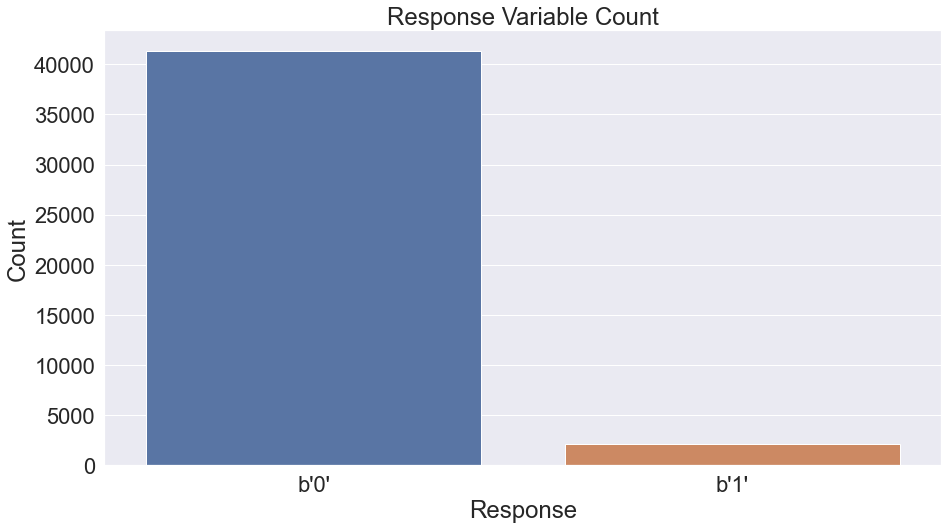

In [6]:
sns.set_style('darkgrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.set(font_scale = 2)
p = sns.countplot(x = 'class', data = df)
p.set_xlabel('Response')
p.set_ylabel('Count')
p.set_title('Response Variable Count')

Rename each of the classes to simply be '0' and '1'.

In [7]:
# Clean up response
df['class'] = df['class'].replace([b'0', b'1'], [0, 1])
df['class'].value_counts()

0    41314
1     2091
Name: class, dtype: int64

Text(0.5, 1.0, 'Response Variable Count')

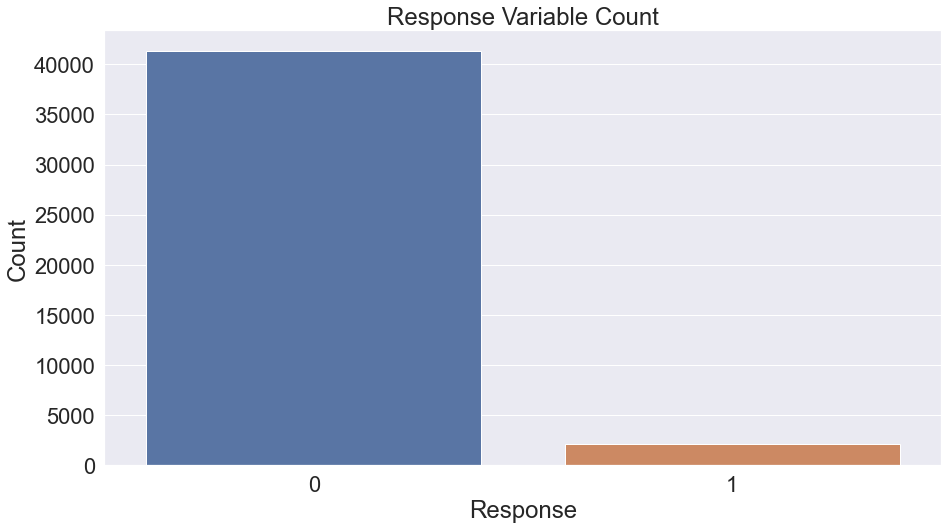

In [8]:
sns.set_style('darkgrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.set(font_scale = 2)
p = sns.countplot(x = 'class', data = df)
p.set_xlabel('Response')
p.set_ylabel('Count')
p.set_title('Response Variable Count')

## Profile the Data

In [9]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df, minimal = True)
# profile.to_file(output_file = "output.html")

## Examine Missing Data

In [10]:
# missingno.matrix(df)

In [11]:
# missingno.matrix(df.loc[df['class']==1])

In [12]:
# missingno.matrix(df.loc[df['class']==0])

In [13]:
missing_cols = []
missing_vals = []

# Calculate the number of missing values
for column in df.columns:
    missing_cols.append(column)
    missing_vals.append(df[column].isnull().sum())
    
# Create a dataframe with the list of attributes and the count of missing values
missing = pd.DataFrame({'Attributes': missing_cols, 
                        'Count': missing_vals})

# Define percentage
missing['Pct'] = (missing['Count'] / missing['Count'].sum()) * 100

# Sort 'Pct' from smallest to largest
missing = missing.sort_values('Pct', ascending = True)

# Format 'Pct' as a percentage
missing.style.format({
    'Pct': '{:,.2%}'.format
})

,Attributes,Count,Pct
64,class,0,0.00%
54,Attr55,1,0.24%
58,Attr59,7,1.69%
56,Attr57,7,1.69%
50,Attr51,8,1.94%
37,Attr38,8,1.94%
35,Attr36,8,1.94%
34,Attr35,8,1.94%
28,Attr29,8,1.94%
24,Attr25,8,1.94%


In [14]:
df = df.drop(['Attr45', 'Attr60', 'Attr27', 'Attr21', 'Attr37'], axis = 1)
df.shape

(43405, 60)

## Correlation

Text(0.5, 1.0, 'Correlation >= 0.8')

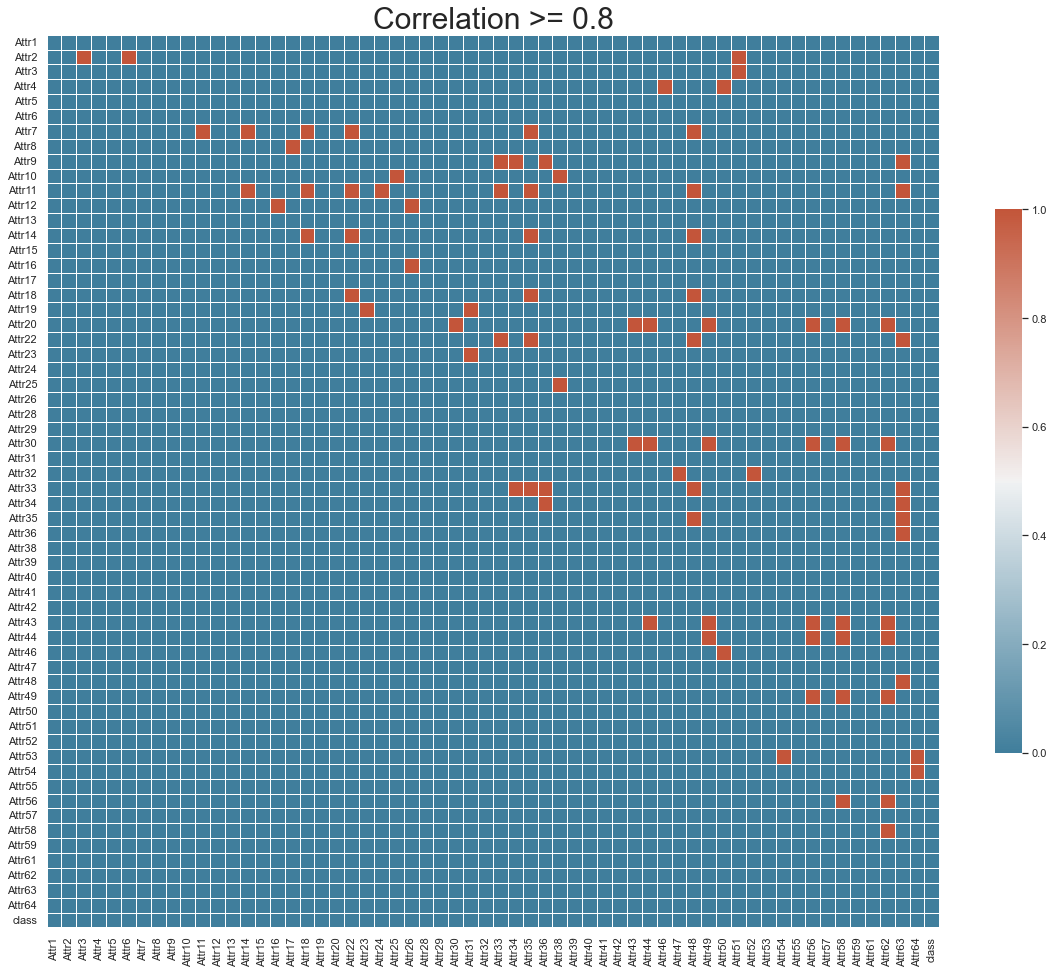

In [15]:
corr = df[df.select_dtypes(include = "number").columns].corr().abs()
upper_tri = corr.where(np.triu(np.ones(corr.shape), k = 1).astype(np.bool))

sns.set_theme(style = "white")
plt.subplots(figsize = (20,20))
sns.heatmap(upper_tri >= 0.8, 
            cmap = sns.diverging_palette(230, 
                                         20, 
                                         as_cmap = True), 
            vmax = 1, 
            center = 0.5,
            annot = False,
            square = True, 
            linewidths = .5, 
            cbar_kws = {"shrink": .5}).set_title('Correlation >= 0.8', fontsize = 30)

Text(0.5, 1.0, 'Correlation >= 0.9')

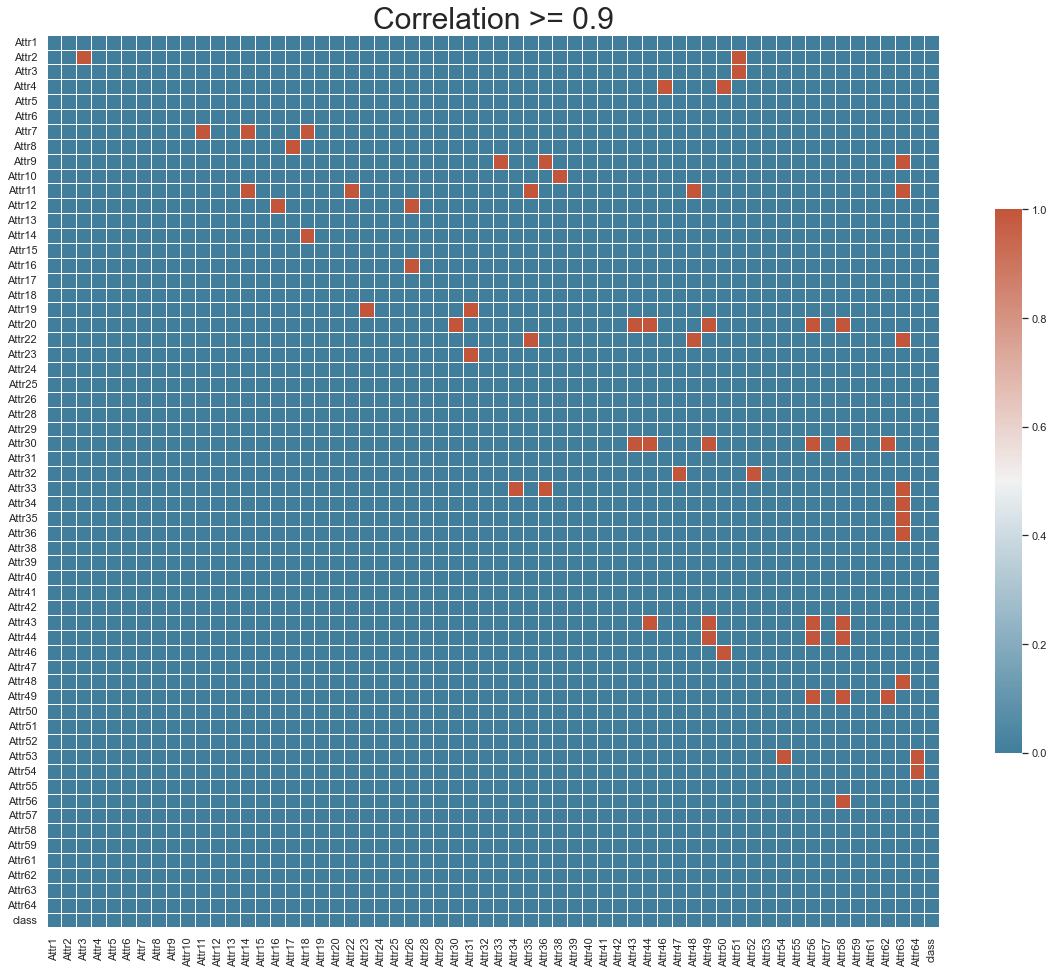

In [16]:
corr = df[df.select_dtypes(include = "number").columns].corr().abs()
upper_tri = corr.where(np.triu(np.ones(corr.shape),k = 1).astype(np.bool))
sns.set_theme(style = "dark")
plt.subplots(figsize = (20,20))
sns.heatmap(upper_tri >= 0.9, 
            cmap = sns.diverging_palette(230, 
                                         20, 
                                         as_cmap = True), 
            vmax = 1, 
            center = 0.5,
            annot = False,
            square = True, 
            linewidths = .5, 
            cbar_kws = {"shrink": .5}).set_title('Correlation >= 0.9', fontsize = 30)

Text(0.5, 1.0, 'Correlation >= 0.95')

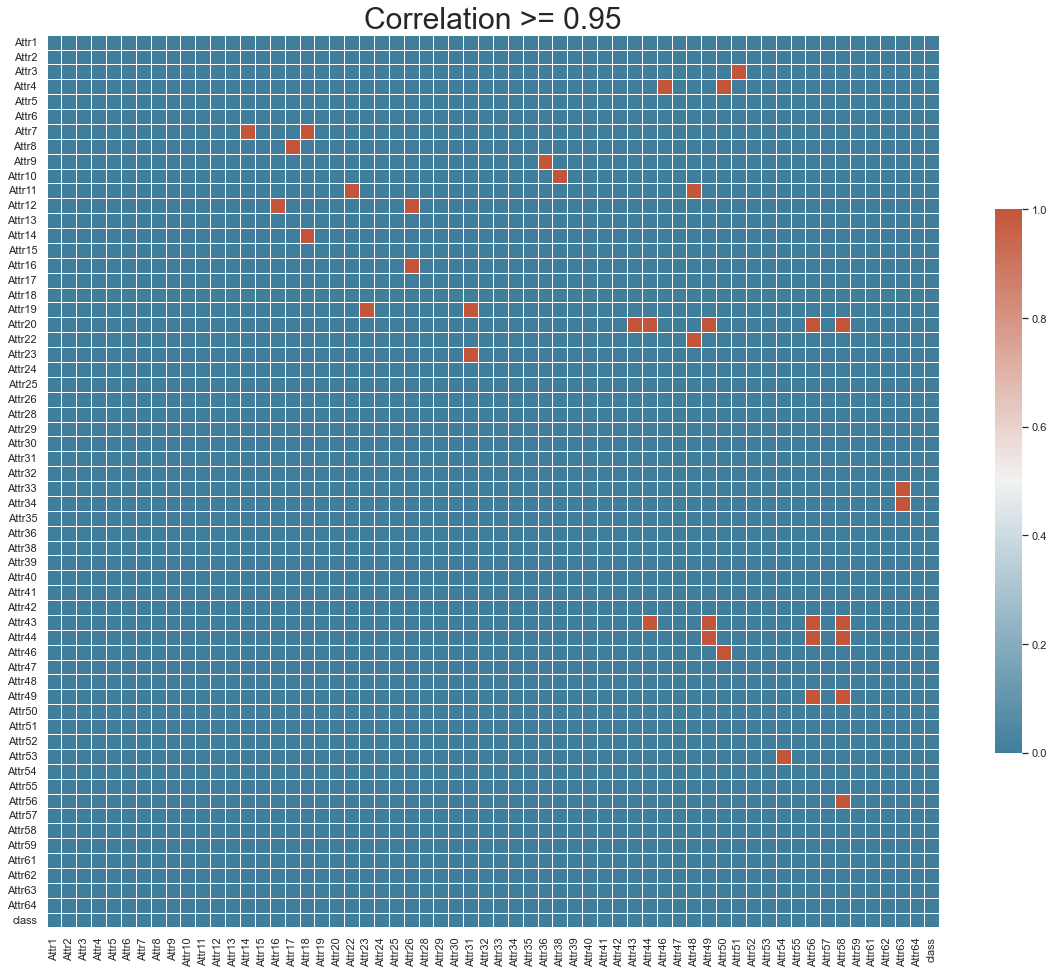

In [17]:
corr = df[df.select_dtypes(include = "number").columns].corr().abs()
upper_tri = corr.where(np.triu(np.ones(corr.shape),k = 1).astype(np.bool))
sns.set_theme(style = "dark")
plt.subplots(figsize = (20,20))
sns.heatmap(upper_tri >= 0.95, 
            cmap = sns.diverging_palette(230, 
                                         20, 
                                         as_cmap = True), 
            vmax = 1, 
            center = 0.5,
            annot = False,
            square = True, 
            linewidths = .5, 
            cbar_kws = {"shrink": .5}).set_title('Correlation >= 0.95', fontsize = 30)

Text(0.5, 1.0, 'Correlation >= 0.98')

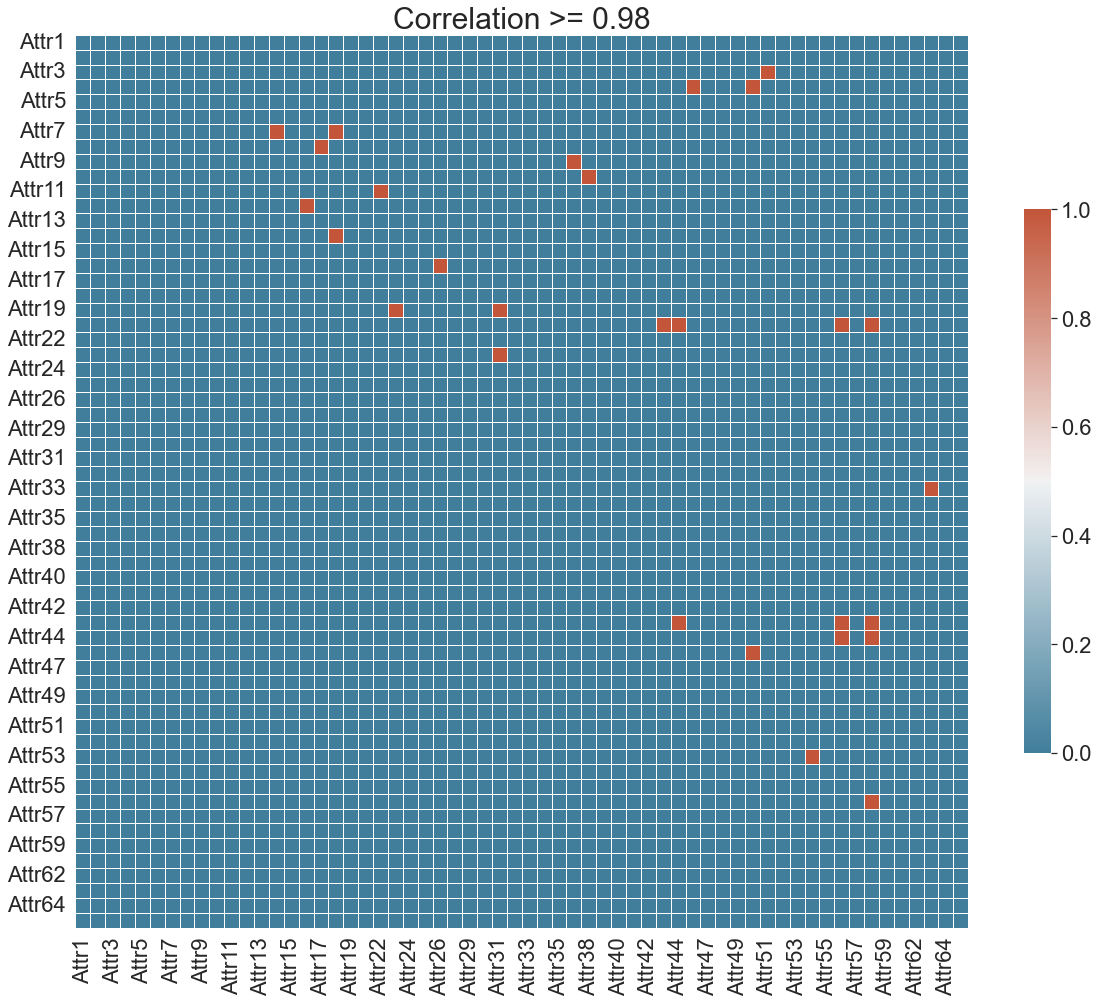

In [18]:
corr = df[df.select_dtypes(include = "number").columns].corr().abs()
upper_tri = corr.where(np.triu(np.ones(corr.shape),k = 1).astype(np.bool))
sns.set_theme(style = "dark")
sns.set(font_scale = 2)
plt.subplots(figsize = (20,20))
sns.heatmap(upper_tri >= 0.98, 
            cmap = sns.diverging_palette(230, 
                                         20, 
                                         as_cmap = True), 
            vmax = 1, 
            center = 0.5,
            annot = False,
            square = True, 
            linewidths = .5, 
            cbar_kws = {"shrink": .5}).set_title('Correlation >= 0.98', fontsize = 30)

In [19]:
# Check for correlation greater than 0.98
[column for column in upper_tri.columns if any(upper_tri[column] >= 0.98)]

['Attr14',
 'Attr16',
 'Attr17',
 'Attr18',
 'Attr22',
 'Attr23',
 'Attr26',
 'Attr31',
 'Attr36',
 'Attr38',
 'Attr43',
 'Attr44',
 'Attr46',
 'Attr50',
 'Attr51',
 'Attr54',
 'Attr56',
 'Attr58',
 'Attr63']

In [20]:
# Drop highly correlated variables
cols_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= 0.98)]
df.drop(cols_to_drop, axis = 1, inplace = True)

In [21]:
df.shape

(43405, 41)

### Final Check

<AxesSubplot:>

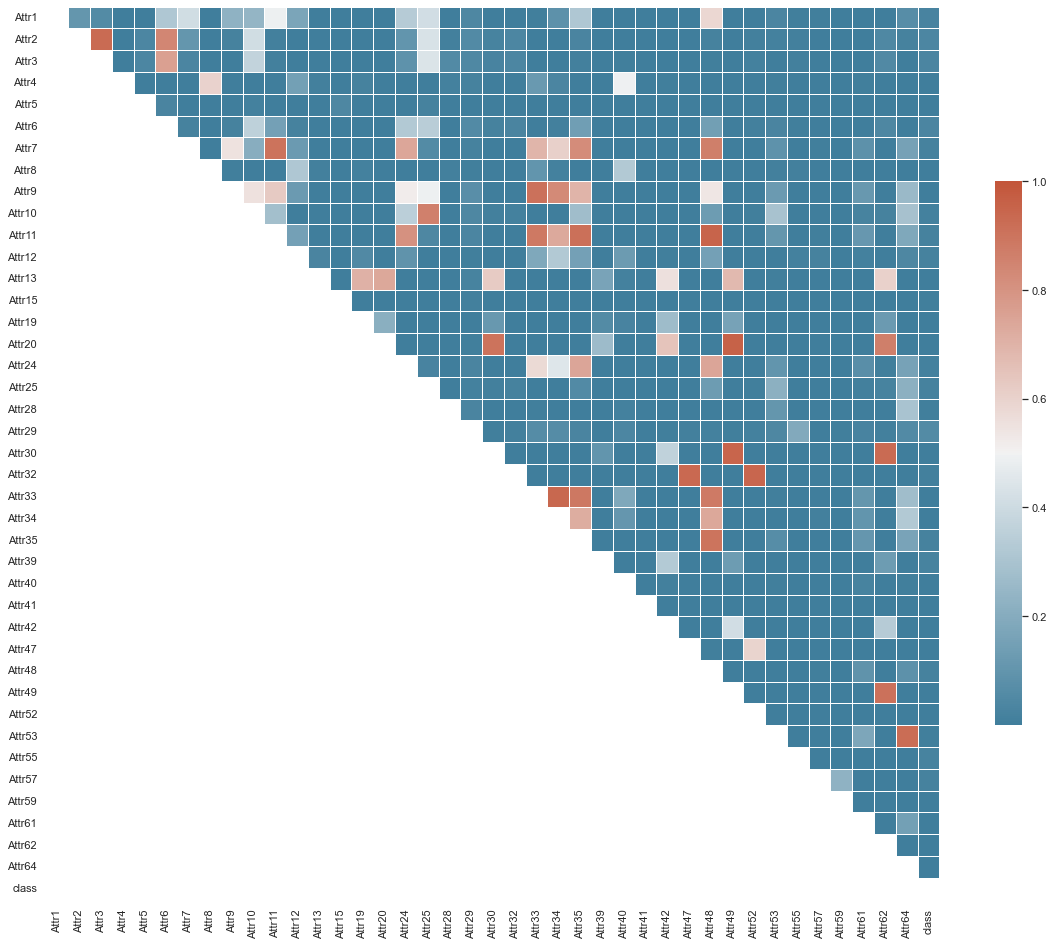

In [22]:
corr = df[df.select_dtypes(include = "number").columns].corr().abs()
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))

sns.set_theme(style = "white")
plt.subplots(figsize = (20,20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(upper_tri, 
            cmap = cmap, 
            vmax = 1, 
            center = 0.5,
            annot = False,
            square = True, 
            linewidths = .5, 
            cbar_kws = {"shrink": .5})

## Helper Functions

In [23]:
def get_acc_score(model, x, y):
    return model.score(x, y)
  
def plot_roc_curve_custom(x_test, y_test, model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(x_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, 
             tpr, 
             color = 'darkorange', 
             label = 'Randomized Search CV (AUC = ' + str(round(roc_auc, 5)) + ')')
    plt.plot([0, 1], 
             [0, 1], 
             color = 'navy', lw = 2, linestyle='--')
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('Receiver operating characteristic',fontdict={'fontsize':20},pad=15)
    
def get_confusion_matrix(y, yhat, title = "Confusion Matrix"):
    cm_n = confusion_matrix(y, yhat)
    ax = sns.heatmap(cm_n,
                     cmap = 'Blues',
                     nnot = True,
                     fmt = '2d',
                     xticklabels = ['Not Bankrupt','Bankrupt'], 
                     yticklabels = ['Not Bankrupt','Bankrupt'])
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    ax.set_title(title,fontdict = {'fontsize':20}, pad = 10)
    
def get_classification_report(x_train, y_train, x_test, y_test, pred, model):
    """
    This function is used to get comprehensive classification report:
    Training Accuracy, Test Accuracy, print classification_report
    plot confusion matrix, and plot roc curve.
    """
    print(f"Train accuracy: {get_acc_score(model, x_train, y_train):,.5f}")
    print("Test result:")
    print(classification_report(y_test,pred))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1], pos_label=1)
    print(f"Test AUC: {auc(fpr, tpr):,.5f}")
    plot_roc_curve_custom(x_test, y_test, model)
    plot_confusion_matrix(model, x_test, y_test,colorbar=False)
    plt.grid(False)

def cv_common(df, columns):
    cv_result_summary = df[columns]
    cv_result_summary.index  = np.arange(1,len(cv_result_summary)+1)
    cv_result_summary = cv_result_summary.reset_index()
    return cv_result_summary
    

def cv_summary(estimator, columns):
    df = pd.DataFrame(estimator.cv_results_)
    cv_result_summary = cv_common(df, columns)
    cv_result_summary = cv_result_summary.rename(columns = {
        "index": "param_combination",
        "mean_test_score": "mean_validation_score",
        "rank_test_score": "rank_validation_score"
    })
    return cv_result_summary

## Model Prep

In [25]:
# Prepare test and train data
X = df.loc[:, df.columns != 'class'].values
y = df['class'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 1, shuffle = True, stratify = y)

# Impute
impute_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
impute_mean.fit(X_train)
X_train = impute_mean.transform(X_train)
X_test = impute_mean.transform(X_test)

# Normalize the data
transformer = RobustScaler().fit(X_train)
transformer = RobustScaler().fit(X_test)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

## Model Building

### Random Forest Grid Search

In [26]:
params_rf = {
    "model__n_estimators": [250, 500, 750, 1000],
    "model__criterion": ['gini','entropy'],
    "model__max_depth":[5, 10, 15, 20],
    "model__min_samples_split":[4, 6, 8, 10],
    "model__n_jobs": [-1],
    "model__class_weight":["balanced"]
}

cv = StratifiedKFold(n_splits = 10, 
                     shuffle = True, 
                     random_state = 1)

In [27]:
%%time

# Define preprocessing for columns
rfc = RandomForestClassifier(random_state = 1)

rf_pipeline = Pipeline(steps=[('preprocessing', preprocessing),('model', rfc)])

# Fit
clf_rfc = RandomizedSearchCV(rf_pipeline, 
                             params_rf, 
                             cv = cv, 
                             scoring = 'roc_auc',
                             n_jobs = -1, 
                             verbose = 15, 
                             return_train_score = True)

search_rfc = clf_rfc.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
CPU times: user 1min 50s, sys: 725 ms, total: 1min 51s
Wall time: 8min 47s


In [28]:
# Evaluate model
y_hat_rf_test = search_rfc.predict(X_test)
accuracy_score(y_hat_rf_test, y_test)

0.9455131897246861

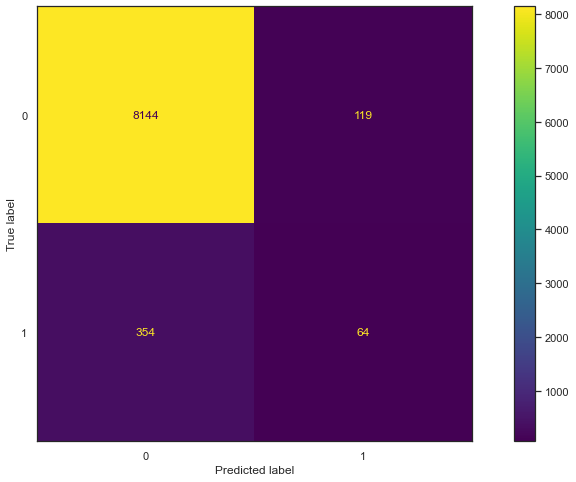

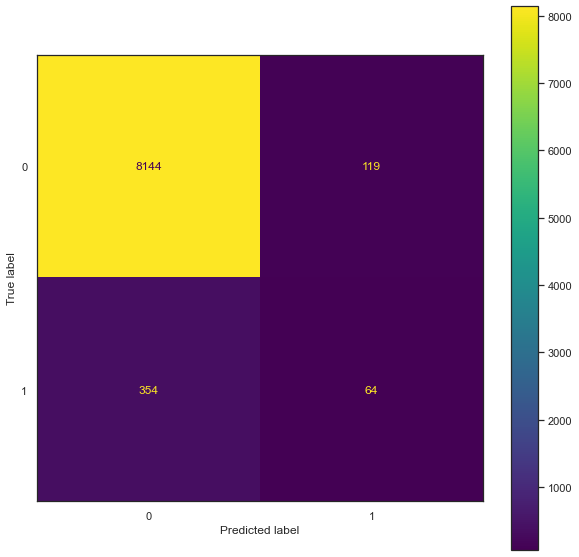

In [29]:
# Confusion matrix
confusion_matrix(y_test, y_hat_rf_test)
disp = ConfusionMatrixDisplay.from_estimator(search_rfc, X_test, y_test)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax = ax)

In [30]:
# Precision and recall
print("Recall:", recall_score(y_test, y_hat_rf_test, pos_label = 1, average = 'binary'))
print("Precision:", precision_score(y_test, y_hat_rf_test, pos_label = 1, average = 'binary'))

Recall: 0.15311004784688995
Precision: 0.34972677595628415


Train accuracy: 0.99895
Test result:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      8263
           1       0.35      0.15      0.21       418

    accuracy                           0.95      8681
   macro avg       0.65      0.57      0.59      8681
weighted avg       0.93      0.95      0.94      8681

Test AUC: 0.86046


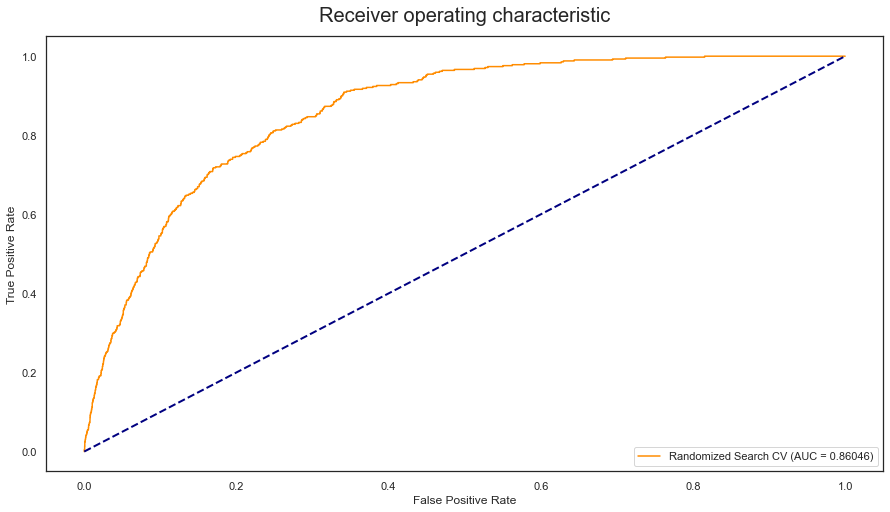

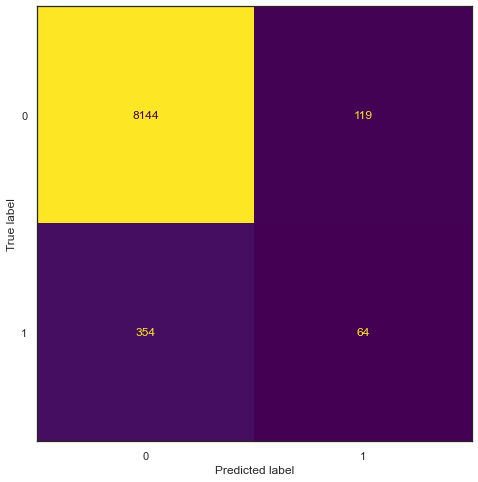

In [31]:
get_classification_report(X_train, y_train, X_test, y_test, y_hat_rf_test, search_rfc)

## XGBoost

In [32]:
X_train_xg = preprocessing.fit_transform(X_train)
X_test_xg = preprocessing.transform(X_test)

dtrain = xgboost.DMatrix(X_train_xg, label=y_train)
dtest = xgboost.DMatrix(X_test_xg, label=y_test)

evallist = [(dtrain,'train'), (dtest,'eval')]

In [33]:
num_round = 1000
param = {
    'max_depth':10,
    'objective':'binary:logistic',
    'eval_metric':'logloss',
    'eta': 0.01
}

In [34]:
%%time
xg_model = xgboost.cv(params = param,
                      dtrain = dtrain,
                      num_boost_round = num_round, 
                      nfold = 5, 
                      verbose_eval = False, 
                      stratified = True,
                      early_stopping_rounds = 5,
                      seed = 1)

CPU times: user 42min 49s, sys: 28.4 s, total: 43min 18s
Wall time: 2min 46s


In [35]:
xg_model.head()

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.684635,0.000032,0.684912,0.000020
1,0.676306,0.000068,0.676835,0.000029
2,0.668136,0.000098,0.668908,0.000027
3,0.660119,0.000137,0.661150,0.000032
4,0.652246,0.000162,0.653531,0.000041


In [36]:
xg_model.shape

(632, 4)

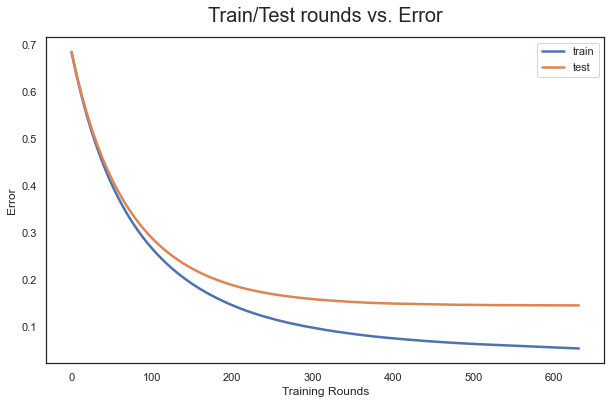

In [37]:
def plot_early_stop_rounds():
    plt.subplots(figsize=(10, 6))
    plt.plot(xg_model['train-logloss-mean'],lw = 2.5, label = 'train')
    plt.plot(xg_model['test-logloss-mean'],lw = 2.5, label = 'test')
    plt.title('Train/Test rounds vs. Error',fontdict = {'fontsize':20}, pad = 15)
    plt.ylabel('Error')
    plt.xlabel('Training Rounds')
    plt.legend()
    plt.show()
plot_early_stop_rounds()

### Search for best parameters using sklearn wrapper

In [38]:
X_train_xg = preprocessing.fit_transform(X_train)
X_test_xg = preprocessing.transform(X_test)

In [39]:
search_space = [
    {
        "model__learning_rate"    : [0.01, 0.1] ,
        "model__max_depth"        : [7, 8, 9],
        "model__subsample"        : [0.7, 0.9, 1],
        "model__gamma"            : [ 0.1, 0.4, 0.6],
     }  
]

In [44]:
## %%time
model_xgb = xgboost.XGBClassifier(
    n_estimators = 1000,
    use_label_encoder = False, 
    objective = "binary:logistic", 
    random_state = 1,
)

fit_params={"model__early_stopping_rounds": 100, 
            "model__eval_metric" : "auc", 
            "model__verbose":False,
            "model__eval_set" : [[X_test_xg, y_test]]}

xgb_pipeline = Pipeline(steps=[('preprocessing',preprocessing),
                               ('model',model_xgb)])

clf_xgb = RandomizedSearchCV(xgb_pipeline,
                             search_space,
                             cv = cv, 
                             scoring = 'roc_auc',
                             n_iter = 10,
                             n_jobs = -1, 
                             verbose = 15, 
                             return_train_score = True, 
                             random_state = 1)

search_clf_xgb = clf_xgb.fit(X_train, y_train, **fit_params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in

KeyboardInterrupt: 

In [41]:
# Where did the best estimator and best_iteration occur 
search_clf_xgb.best_estimator_.named_steps['model'].best_iteration

193

In [42]:
# Get cross validation result
best_xgb_columns = ["param_model__learning_rate","param_model__max_depth",
                    "param_model__subsample","param_model__gamma","mean_train_score",
                    "mean_test_score","rank_test_score"]
df_best_xgb_cv_results = cv_summary(search_clf_xgb, best_xgb_columns)
df_best_xgb_cv_results

,param_combination,param_model__learning_rate,param_model__max_depth,param_model__subsample,param_model__gamma,mean_train_score,mean_validation_score,rank_validation_score
0,1,0.1,8,0.7,0.4,0.952487,0.854422,5
1,2,0.01,7,1,0.1,0.853947,0.798215,9
2,3,0.01,9,1,0.6,0.859186,0.790699,10
3,4,0.1,8,1,0.4,0.947815,0.853998,6
4,5,0.1,8,0.9,0.4,0.985685,0.874799,1
5,6,0.1,7,1,0.6,0.952414,0.859183,4
6,7,0.1,9,0.9,0.4,0.983411,0.874427,2
7,8,0.01,8,0.9,0.6,0.867873,0.803019,7
8,9,0.1,7,0.9,0.6,0.972338,0.868602,3
9,10,0.01,7,0.9,0.4,0.855214,0.799729,8


Train accuracy: 0.99983
Test result:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      8263
           1       0.51      0.11      0.18       418

    accuracy                           0.95      8681
   macro avg       0.73      0.55      0.58      8681
weighted avg       0.94      0.95      0.94      8681

Test AUC: 0.89750


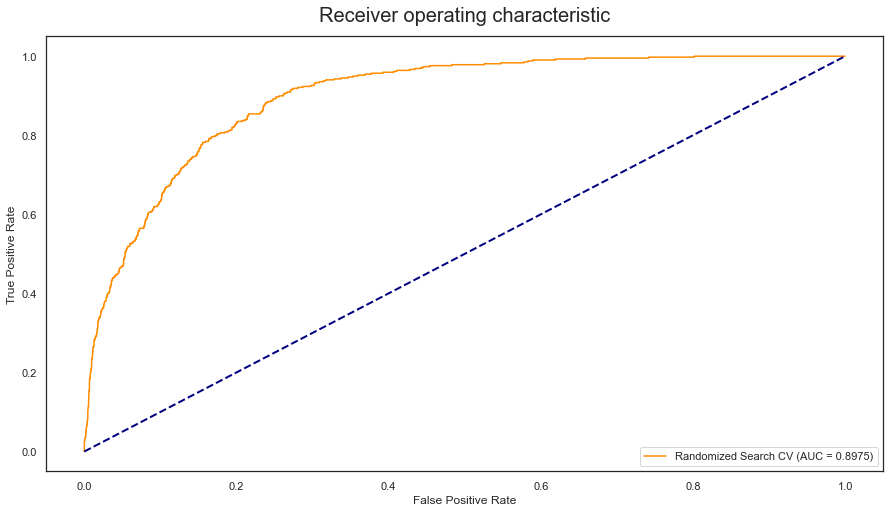

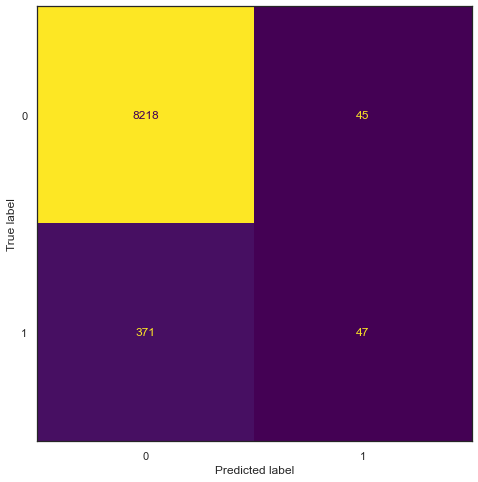

[CV 1/10; 1/10] START model__class_weight=balanced, model__criterion=gini, model__max_depth=15, model__min_samples_split=10, model__n_estimators=250, model__n_jobs=-1
[CV 1/10; 1/10] END model__class_weight=balanced, model__criterion=gini, model__max_depth=15, model__min_samples_split=10, model__n_estimators=250, model__n_jobs=-1;, score=(train=0.990, test=0.838) total time=  42.9s
[CV 7/10; 2/10] START model__class_weight=balanced, model__criterion=gini, model__max_depth=20, model__min_samples_split=10, model__n_estimators=250, model__n_jobs=-1
[CV 7/10; 2/10] END model__class_weight=balanced, model__criterion=gini, model__max_depth=20, model__min_samples_split=10, model__n_estimators=250, model__n_jobs=-1;, score=(train=0.997, test=0.834) total time=  43.3s
[CV 3/10; 4/10] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=15, model__min_samples_split=8, model__n_estimators=500, model__n_jobs=-1
[CV 3/10; 4/10] END model__class_weight=balanced, model__crit

[CV 5/10; 2/10] START model__class_weight=balanced, model__criterion=gini, model__max_depth=20, model__min_samples_split=10, model__n_estimators=250, model__n_jobs=-1
[CV 5/10; 2/10] END model__class_weight=balanced, model__criterion=gini, model__max_depth=20, model__min_samples_split=10, model__n_estimators=250, model__n_jobs=-1;, score=(train=0.997, test=0.866) total time=  46.6s
[CV 9/10; 3/10] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=20, model__min_samples_split=8, model__n_estimators=500, model__n_jobs=-1
[CV 9/10; 3/10] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=20, model__min_samples_split=8, model__n_estimators=500, model__n_jobs=-1;, score=(train=0.999, test=0.864) total time= 1.8min
[CV 8/10; 5/10] START model__class_weight=balanced, model__criterion=gini, model__max_depth=20, model__min_samples_split=8, model__n_estimators=250, model__n_jobs=-1
[CV 8/10; 5/10] END model__class_weight=balanced, model__cri

[CV 2/10; 2/10] START model__class_weight=balanced, model__criterion=gini, model__max_depth=20, model__min_samples_split=10, model__n_estimators=250, model__n_jobs=-1
[CV 2/10; 2/10] END model__class_weight=balanced, model__criterion=gini, model__max_depth=20, model__min_samples_split=10, model__n_estimators=250, model__n_jobs=-1;, score=(train=0.997, test=0.865) total time=  46.8s
[CV 2/10; 4/10] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=15, model__min_samples_split=8, model__n_estimators=500, model__n_jobs=-1
[CV 2/10; 4/10] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=15, model__min_samples_split=8, model__n_estimators=500, model__n_jobs=-1;, score=(train=0.995, test=0.865) total time= 1.8min
[CV 2/10; 5/10] START model__class_weight=balanced, model__criterion=gini, model__max_depth=20, model__min_samples_split=8, model__n_estimators=250, model__n_jobs=-1
[CV 2/10; 5/10] END model__class_weight=balanced, model__cri

[CV 3/10; 2/10] START model__class_weight=balanced, model__criterion=gini, model__max_depth=20, model__min_samples_split=10, model__n_estimators=250, model__n_jobs=-1
[CV 3/10; 2/10] END model__class_weight=balanced, model__criterion=gini, model__max_depth=20, model__min_samples_split=10, model__n_estimators=250, model__n_jobs=-1;, score=(train=0.997, test=0.833) total time=  46.6s
[CV 10/10; 3/10] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=20, model__min_samples_split=8, model__n_estimators=500, model__n_jobs=-1
[CV 10/10; 3/10] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=20, model__min_samples_split=8, model__n_estimators=500, model__n_jobs=-1;, score=(train=0.999, test=0.867) total time= 1.8min
[CV 7/10; 5/10] START model__class_weight=balanced, model__criterion=gini, model__max_depth=20, model__min_samples_split=8, model__n_estimators=250, model__n_jobs=-1
[CV 7/10; 5/10] END model__class_weight=balanced, model__c

[CV 4/10; 1/10] START model__class_weight=balanced, model__criterion=gini, model__max_depth=15, model__min_samples_split=10, model__n_estimators=250, model__n_jobs=-1
[CV 4/10; 1/10] END model__class_weight=balanced, model__criterion=gini, model__max_depth=15, model__min_samples_split=10, model__n_estimators=250, model__n_jobs=-1;, score=(train=0.991, test=0.844) total time=  44.7s
[CV 2/10; 3/10] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=20, model__min_samples_split=8, model__n_estimators=500, model__n_jobs=-1
[CV 2/10; 3/10] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=20, model__min_samples_split=8, model__n_estimators=500, model__n_jobs=-1;, score=(train=0.999, test=0.873) total time= 1.8min
[CV 5/10; 5/10] START model__class_weight=balanced, model__criterion=gini, model__max_depth=20, model__min_samples_split=8, model__n_estimators=250, model__n_jobs=-1
[CV 5/10; 5/10] END model__class_weight=balanced, model__cri

[CV 6/10; 1/10] START model__class_weight=balanced, model__criterion=gini, model__max_depth=15, model__min_samples_split=10, model__n_estimators=250, model__n_jobs=-1
[CV 6/10; 1/10] END model__class_weight=balanced, model__criterion=gini, model__max_depth=15, model__min_samples_split=10, model__n_estimators=250, model__n_jobs=-1;, score=(train=0.990, test=0.838) total time=  44.7s
[CV 1/10; 3/10] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=20, model__min_samples_split=8, model__n_estimators=500, model__n_jobs=-1
[CV 1/10; 3/10] END model__class_weight=balanced, model__criterion=entropy, model__max_depth=20, model__min_samples_split=8, model__n_estimators=500, model__n_jobs=-1;, score=(train=0.999, test=0.855) total time= 1.7min
[CV 8/10; 4/10] START model__class_weight=balanced, model__criterion=entropy, model__max_depth=15, model__min_samples_split=8, model__n_estimators=500, model__n_jobs=-1
[CV 8/10; 4/10] END model__class_weight=balanced, model__

In [43]:
y_hat_xgb = search_clf_xgb.predict(X_test)
get_classification_report(X_train, y_train, X_test, y_test, y_hat_xgb, search_clf_xgb)